# Plot Label Resampling Performance

In [1]:
from pathlib import Path

import scipy.stats
import pandas as pd
import plotnine as p9
import plydata as ply

In [2]:
performance_dfs = pd.concat(
    [
        pd.read_csv(str(df_path), sep="\t")
        >> ply.define(lf_num=ply.expressions.if_else("lf_num > 16", 99, "lf_num"))
        >> ply.define(
            lf_num=ply.expressions.case_when(
                {
                    "lf_num==1": "lf_num",
                    "lf_num==6": "lf_num",
                    "lf_num==11": "lf_num",
                    "lf_num==16": "lf_num",
                    "lf_num==99": "lf_num",
                    True: 0,
                }
            )
        )
        >> ply.define(prediction_label='"' + df_path.stem.split("_")[0] + '"')
        >> ply.select("-sampled_lf_name")
        for df_path in Path("output/performance").rglob("*tsv")
    ]
)
performance_dfs = performance_dfs >> ply.select("-epochs", "-l2_param", "-lr_param")
print(performance_dfs.shape)
performance_dfs.head()

(14008, 8)


,lf_num,auroc,aupr,bce_loss,label_source,data_source,model,prediction_label
0,0,0.673485,0.189110,1.112871,GiG_baseline,abstract,tune,GiG
1,0,0.663729,0.305850,0.926406,GiG_baseline,abstract,test,GiG
2,1,0.673485,0.189110,1.112709,DaG,abstract,tune,GiG
3,1,0.664303,0.305925,0.926120,DaG,abstract,test,GiG
4,1,0.673902,0.237828,1.123652,DaG,abstract,tune,GiG


In [3]:
entity_labels = (
    performance_dfs
    >> ply.select("label_source")
    >> ply.query("not label_source.str.contains('_baseline')")
    >> ply.distinct()
    >> ply.pull("label_source")
)

data_rows = []
df_iterator = performance_dfs >> ply.query("lf_num==0") >> ply.call(".iterrows")
for idx, row in df_iterator:

    for entity in entity_labels:

        if entity == row["label_source"]:
            continue

        data_rows.append(
            {
                "lf_num": 0,
                "aupr": row["aupr"],
                "auroc": row["auroc"],
                "bce_loss": row["bce_loss"],
                "model": row["model"],
                "label_source": entity.split("_")[0],
                "data_source": row["data_source"],
                "prediction_label": row["prediction_label"],
            }
        )

In [4]:
def upper_ci(x):
    return x.mean() + (
        scipy.stats.sem(x) * scipy.stats.t.ppf((1 + 0.95) / 2.0, len(x) - 1)
    )


def lower_ci(x):
    return x.mean() - (
        scipy.stats.sem(x) * scipy.stats.t.ppf((1 + 0.95) / 2.0, len(x) - 1)
    )

In [5]:
performance_ci_df = (
    performance_dfs
    >> ply.query("lf_num != 0")
    >> ply.call(".append", pd.DataFrame.from_records(data_rows))
    >> ply.group_by(
        "lf_num", "label_source", "prediction_label", "data_source", "model"
    )
    >> ply.define(
        aupr_mean="mean(aupr)",
        aupr_upper_ci="upper_ci(aupr)",
        aupr_lower_ci="lower_ci(aupr)",
    )
    >> ply.define(
        auroc_mean="mean(auroc)",
        auroc_upper_ci="upper_ci(auroc)",
        auroc_lower_ci="lower_ci(auroc)",
    )
    >> ply.define(
        bce_mean="mean(bce_loss)",
        bce_upper_ci="upper_ci(bce_loss)",
        bce_lower_ci="lower_ci(bce_loss)",
    )
    >> ply.ungroup()
    >> ply.define(lf_num=ply.expressions.if_else("lf_num==99", '"All"', "lf_num"))
    >> ply.distinct()
)
performance_ci_df.lf_num = pd.Categorical(
    performance_ci_df.lf_num.tolist(),
    ordered=True,
    categories=["0", "1", "6", "11", "16", "All"],
)
performance_ci_df

/home/danich1/anaconda3/envs/snorkeling_full_text/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/danich1/anaconda3/envs/snorkeling_full_text/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars


,lf_num,auroc,aupr,bce_loss,label_source,data_source,model,prediction_label,aupr_mean,aupr_upper_ci,aupr_lower_ci,auroc_mean,auroc_upper_ci,auroc_lower_ci,bce_mean,bce_upper_ci,bce_lower_ci
2,1,0.673485,0.189110,1.112709,DaG,abstract,tune,GiG,0.209217,0.215424,0.203010,0.675178,0.678579,0.671776,1.863560,2.496436,1.230683
3,1,0.664303,0.305925,0.926120,DaG,abstract,test,GiG,0.296460,0.299414,0.293506,0.662261,0.664039,0.660484,1.407624,1.810895,1.004353
4,1,0.673902,0.237828,1.123652,DaG,abstract,tune,GiG,0.209217,0.215424,0.203010,0.675178,0.678579,0.671776,1.863560,2.496436,1.230683
5,1,0.660874,0.287429,0.940100,DaG,abstract,test,GiG,0.296460,0.299414,0.293506,0.662261,0.664039,0.660484,1.407624,1.810895,1.004353
6,1,0.702462,0.256449,1.134735,DaG,abstract,tune,GiG,0.209217,0.215424,0.203010,0.675178,0.678579,0.671776,1.863560,2.496436,1.230683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,0,0.674569,0.475489,0.544531,GiG,abstract,tune,CtD,0.475489,NaN,NaN,0.674569,NaN,NaN,0.544531,NaN,NaN
28,0,0.538901,0.299052,0.563438,DaG,abstract,test,CtD,0.299052,NaN,NaN,0.538901,NaN,NaN,0.563438,NaN,NaN
29,0,0.538901,0.299052,0.563438,CtD,abstract,test,CtD,0.299052,NaN,NaN,0.538901,NaN,NaN,0.563438,NaN,NaN
30,0,0.538901,0.299052,0.563438,CbG,abstract,test,CtD,0.299052,NaN,NaN,0.538901,NaN,NaN,0.563438,NaN,NaN


# Abstracts

## Area Under Precision Recall Curve (AUPR)

### Tune Set

/home/danich1/anaconda3/envs/snorkeling_full_text/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_errorbar : Removed 16 rows containing missing values.


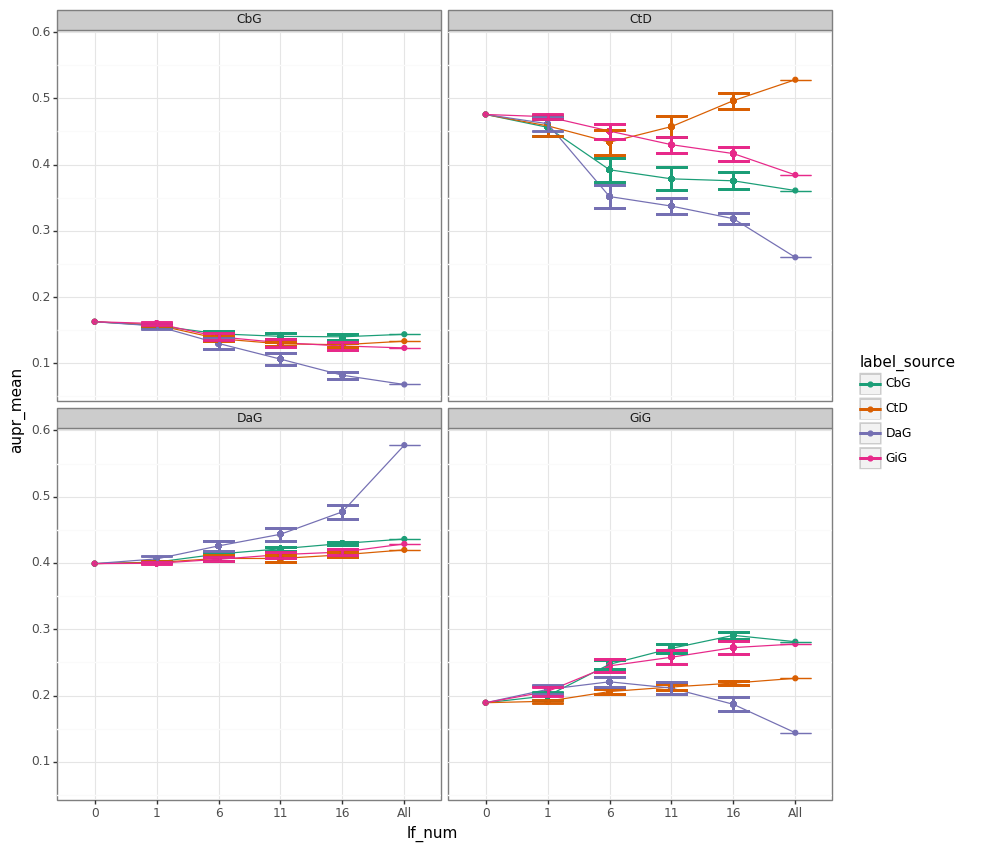

<ggplot: (-9223363260289416041)>


In [6]:
g = (
    p9.ggplot(
        performance_ci_df
        >> ply.query("data_source=='abstract'")
        >> ply.query("model=='tune'")
    )
    + p9.aes(
        x="lf_num",
        y="aupr_mean",
        ymin="aupr_lower_ci",
        ymax="aupr_upper_ci",
        group="label_source",
        color="label_source",
    )
    + p9.geom_point()
    + p9.geom_line()
    + p9.geom_errorbar()
    + p9.facet_wrap("~ prediction_label")
    + p9.theme_bw()
    + p9.theme(figure_size=(10, 10))
    + p9.scale_color_brewer(type="qual", palette=2)
)
print(g)

### Test Set

/home/danich1/anaconda3/envs/snorkeling_full_text/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_errorbar : Removed 16 rows containing missing values.


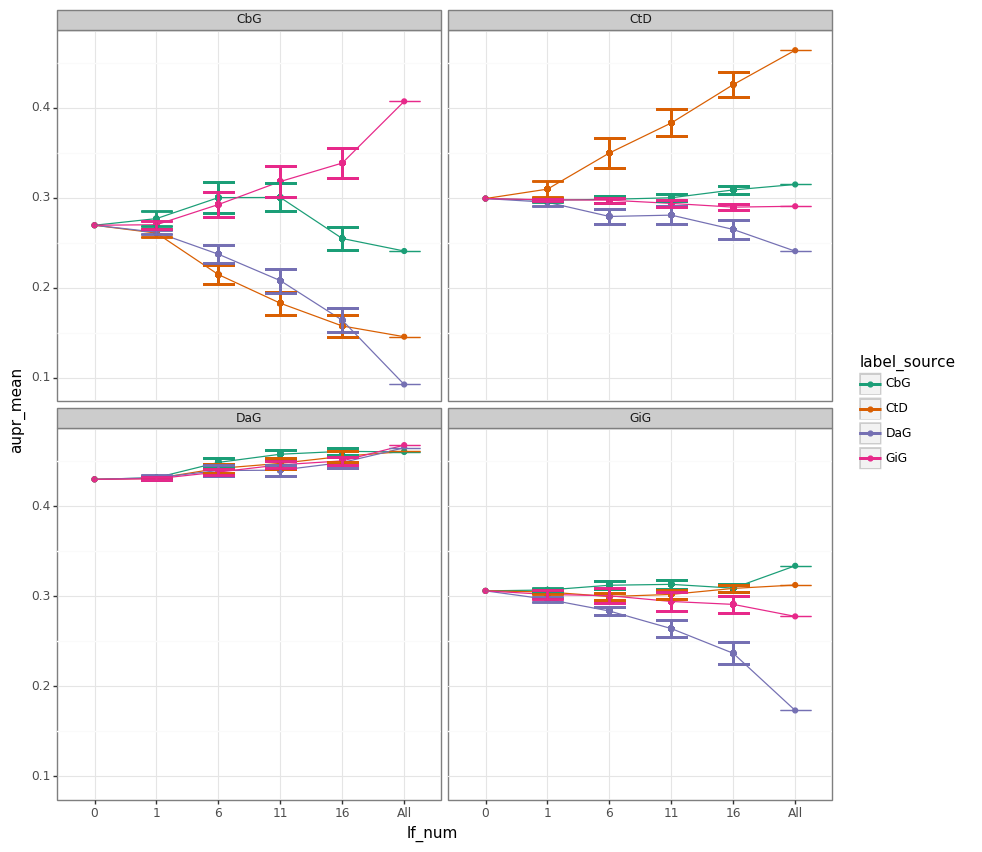

<ggplot: (8776562457194)>


In [7]:
g = (
    p9.ggplot(
        performance_ci_df
        >> ply.query("data_source=='abstract'")
        >> ply.query("model=='test'")
    )
    + p9.aes(
        x="lf_num",
        y="aupr_mean",
        ymin="aupr_lower_ci",
        ymax="aupr_upper_ci",
        group="label_source",
        color="label_source",
    )
    + p9.geom_point()
    + p9.geom_line()
    + p9.geom_errorbar()
    + p9.facet_wrap("~ prediction_label")
    + p9.theme_bw()
    + p9.theme(figure_size=(10, 10))
    + p9.scale_color_brewer(type="qual", palette=2)
)
print(g)

## Area Under Receiver Operating Curve (AUROC)

### Tune Set

/home/danich1/anaconda3/envs/snorkeling_full_text/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_errorbar : Removed 16 rows containing missing values.


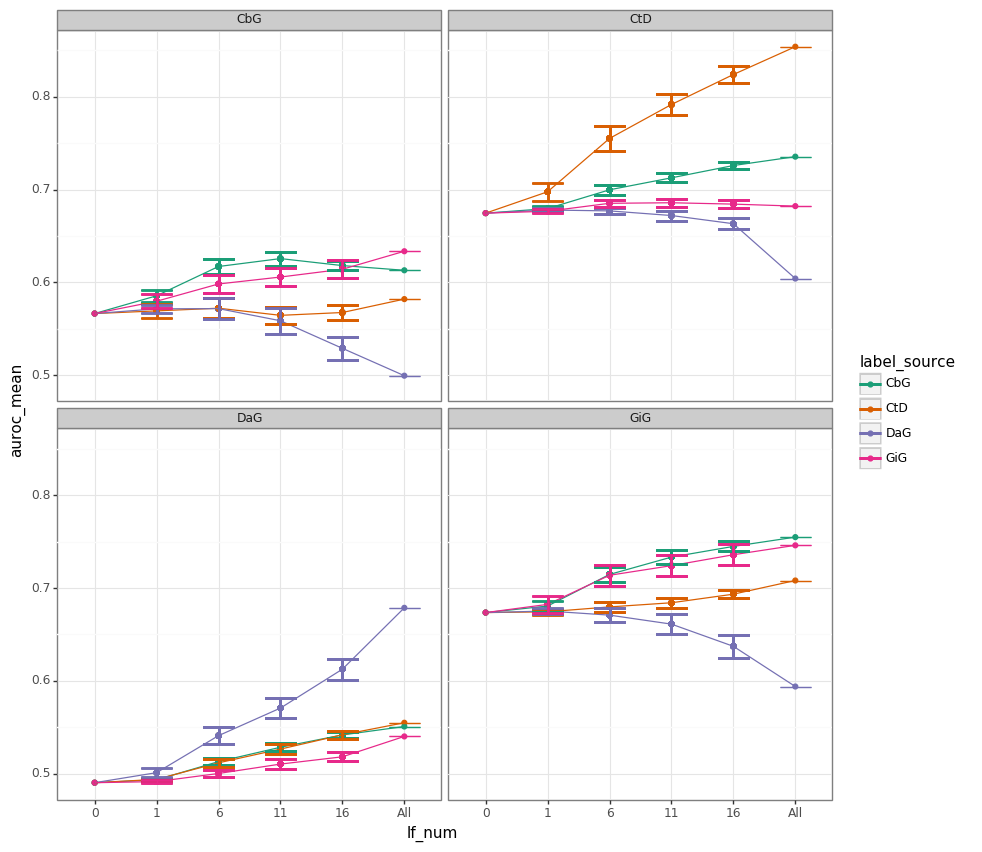

<ggplot: (8776565364456)>


In [8]:
g = (
    p9.ggplot(
        performance_ci_df
        >> ply.query("data_source=='abstract'")
        >> ply.query("model=='tune'")
    )
    + p9.aes(
        x="lf_num",
        y="auroc_mean",
        ymin="auroc_lower_ci",
        ymax="auroc_upper_ci",
        group="label_source",
        color="label_source",
    )
    + p9.geom_point()
    + p9.geom_line()
    + p9.geom_errorbar()
    + p9.facet_wrap("~ prediction_label")
    + p9.theme_bw()
    + p9.theme(figure_size=(10, 10))
    + p9.scale_color_brewer(type="qual", palette=2)
)
print(g)

### Test Set

/home/danich1/anaconda3/envs/snorkeling_full_text/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_errorbar : Removed 16 rows containing missing values.


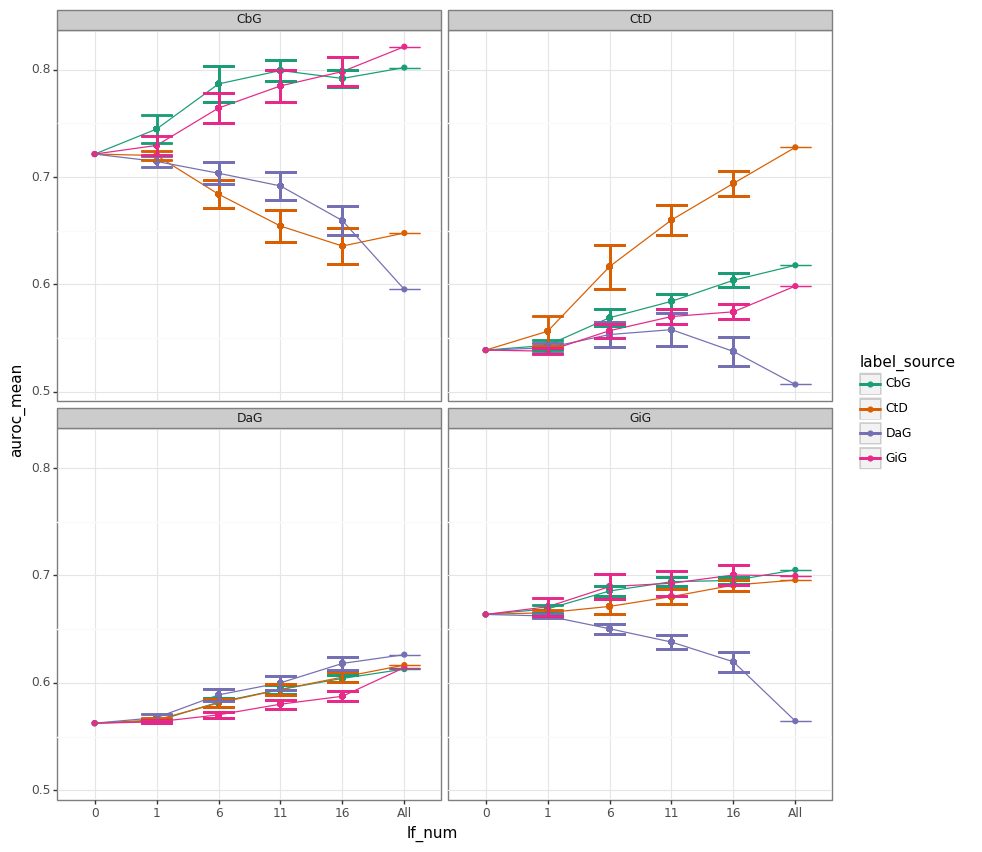

<ggplot: (8776555348081)>


In [9]:
g = (
    p9.ggplot(
        performance_ci_df
        >> ply.query("data_source=='abstract'")
        >> ply.query("model=='test'")
    )
    + p9.aes(
        x="lf_num",
        y="auroc_mean",
        ymin="auroc_lower_ci",
        ymax="auroc_upper_ci",
        group="label_source",
        color="label_source",
    )
    + p9.geom_point()
    + p9.geom_line()
    + p9.geom_errorbar()
    + p9.facet_wrap("~ prediction_label")
    + p9.theme_bw()
    + p9.theme(figure_size=(10, 10))
    + p9.scale_color_brewer(type="qual", palette=2)
)
print(g)

## Binary Cross Entropy Loss

### Tune Set

/home/danich1/anaconda3/envs/snorkeling_full_text/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_errorbar : Removed 16 rows containing missing values.


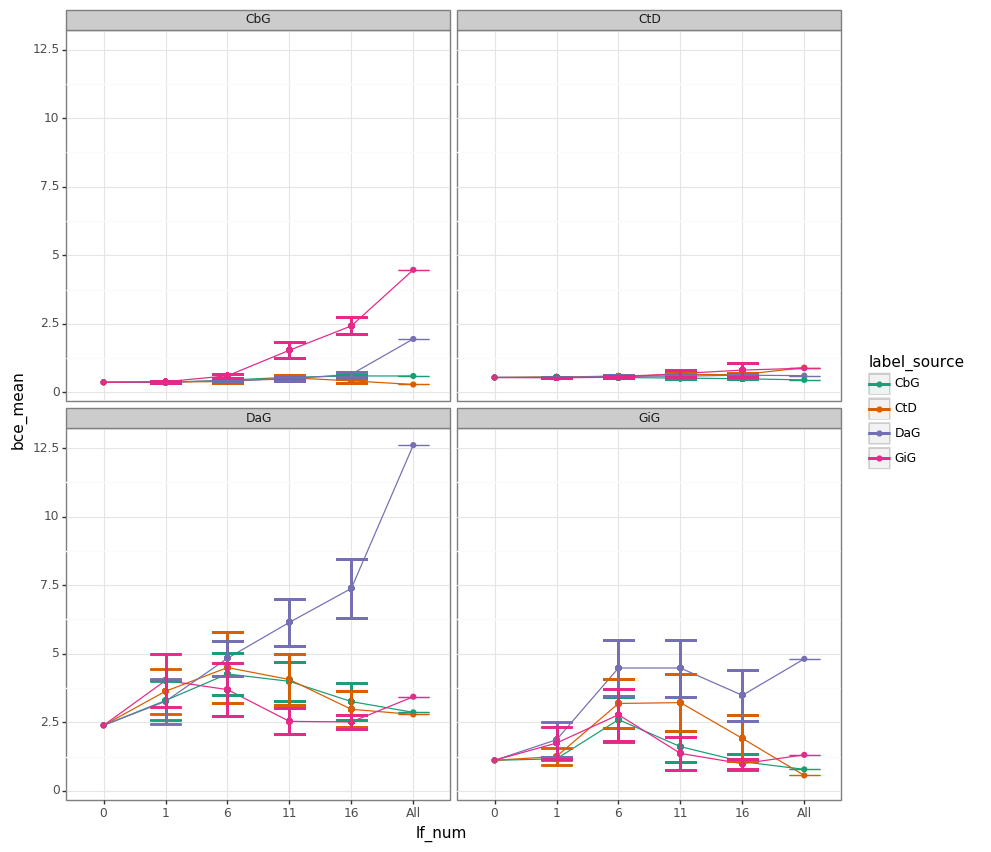

<ggplot: (-9223363260299417351)>


In [10]:
g = (
    p9.ggplot(
        performance_ci_df
        >> ply.query("data_source=='abstract'")
        >> ply.query("model=='tune'")
    )
    + p9.aes(
        x="lf_num",
        y="bce_mean",
        ymin="bce_lower_ci",
        ymax="bce_upper_ci",
        group="label_source",
        color="label_source",
    )
    + p9.geom_point()
    + p9.geom_line()
    + p9.geom_errorbar()
    + p9.facet_wrap("~ prediction_label")
    + p9.theme_bw()
    + p9.theme(figure_size=(10, 10))
    + p9.scale_color_brewer(type="qual", palette=2)
)
print(g)

### Test Set

/home/danich1/anaconda3/envs/snorkeling_full_text/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_errorbar : Removed 16 rows containing missing values.


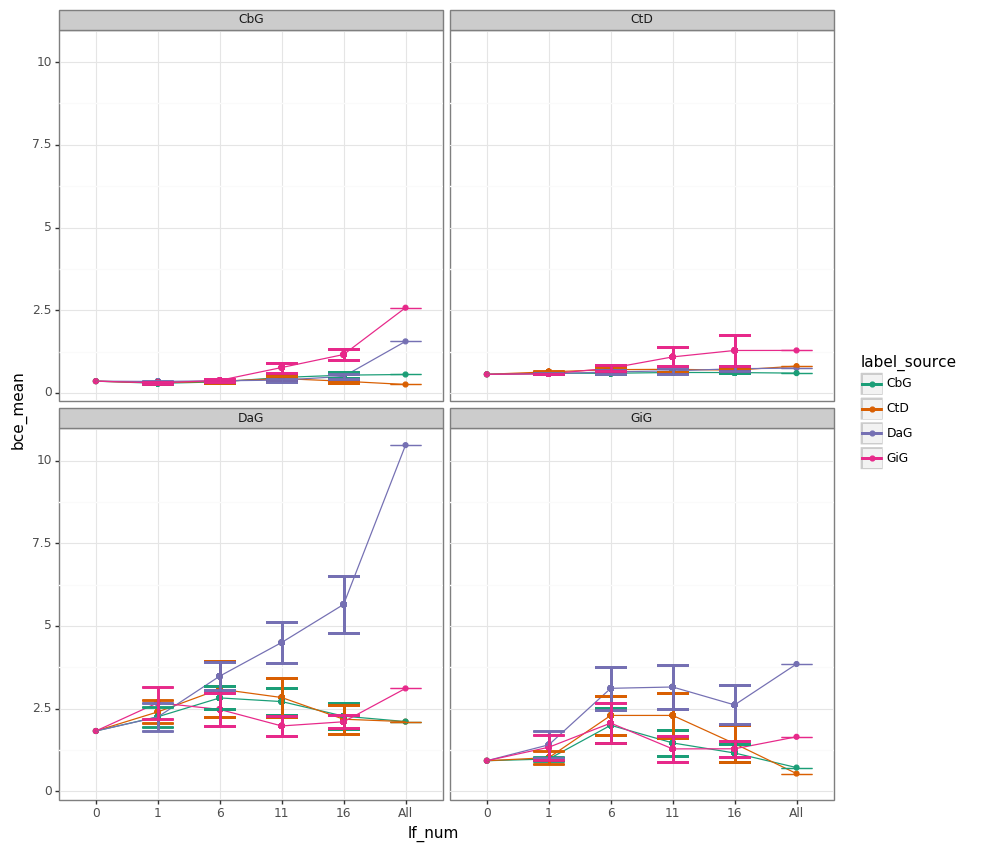

<ggplot: (-9223363260292623707)>


In [11]:
g = (
    p9.ggplot(
        performance_ci_df
        >> ply.query("data_source=='abstract'")
        >> ply.query("model=='test'")
    )
    + p9.aes(
        x="lf_num",
        y="bce_mean",
        ymin="bce_lower_ci",
        ymax="bce_upper_ci",
        group="label_source",
        color="label_source",
    )
    + p9.geom_point()
    + p9.geom_line()
    + p9.geom_errorbar()
    + p9.facet_wrap("~ prediction_label")
    + p9.theme_bw()
    + p9.theme(figure_size=(10, 10))
    + p9.scale_color_brewer(type="qual", palette=2)
)
print(g)

# Full Text

## Area Under Precision Recall Curve (AUPR)

### Tune Set

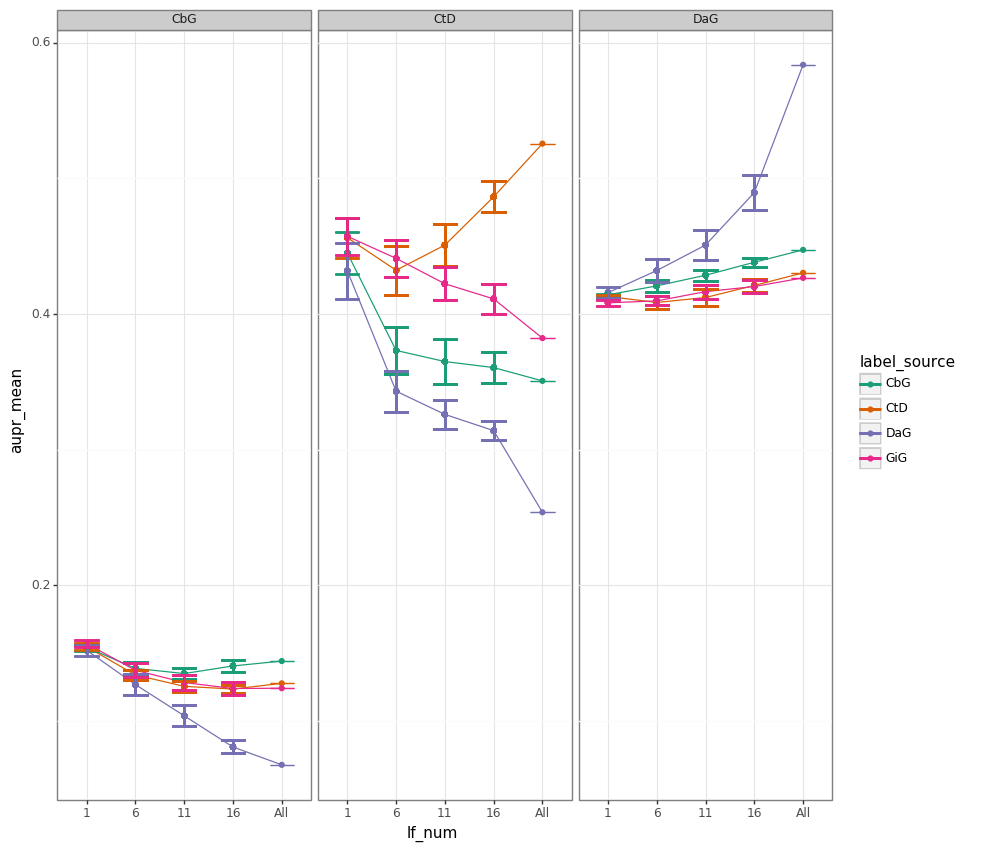

<ggplot: (-9223363260300378508)>


In [12]:
g = (
    p9.ggplot(
        performance_ci_df
        >> ply.query("data_source=='full_text'")
        >> ply.query("model=='tune'")
    )
    + p9.aes(
        x="lf_num",
        y="aupr_mean",
        ymin="aupr_lower_ci",
        ymax="aupr_upper_ci",
        group="label_source",
        color="label_source",
    )
    + p9.geom_point()
    + p9.geom_line()
    + p9.geom_errorbar()
    + p9.facet_wrap("~ prediction_label")
    + p9.theme_bw()
    + p9.theme(figure_size=(10, 10))
    + p9.scale_color_brewer(type="qual", palette=2)
)
print(g)

### Test Set

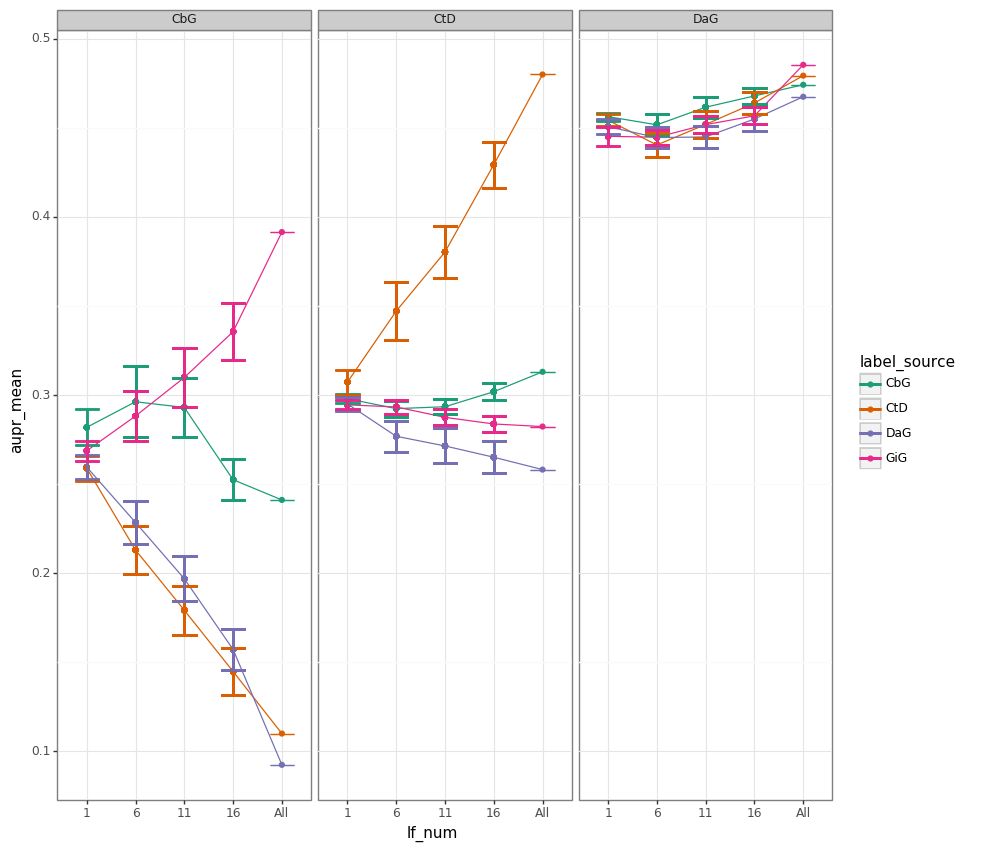

<ggplot: (-9223363260299427759)>


In [13]:
g = (
    p9.ggplot(
        performance_ci_df
        >> ply.query("data_source=='full_text'")
        >> ply.query("model=='test'")
    )
    + p9.aes(
        x="lf_num",
        y="aupr_mean",
        ymin="aupr_lower_ci",
        ymax="aupr_upper_ci",
        group="label_source",
        color="label_source",
    )
    + p9.geom_point()
    + p9.geom_line()
    + p9.geom_errorbar()
    + p9.facet_wrap("~ prediction_label")
    + p9.theme_bw()
    + p9.theme(figure_size=(10, 10))
    + p9.scale_color_brewer(type="qual", palette=2)
)
print(g)

## Area Under Receiver Operating Curve (AUROC)

### Tune Set

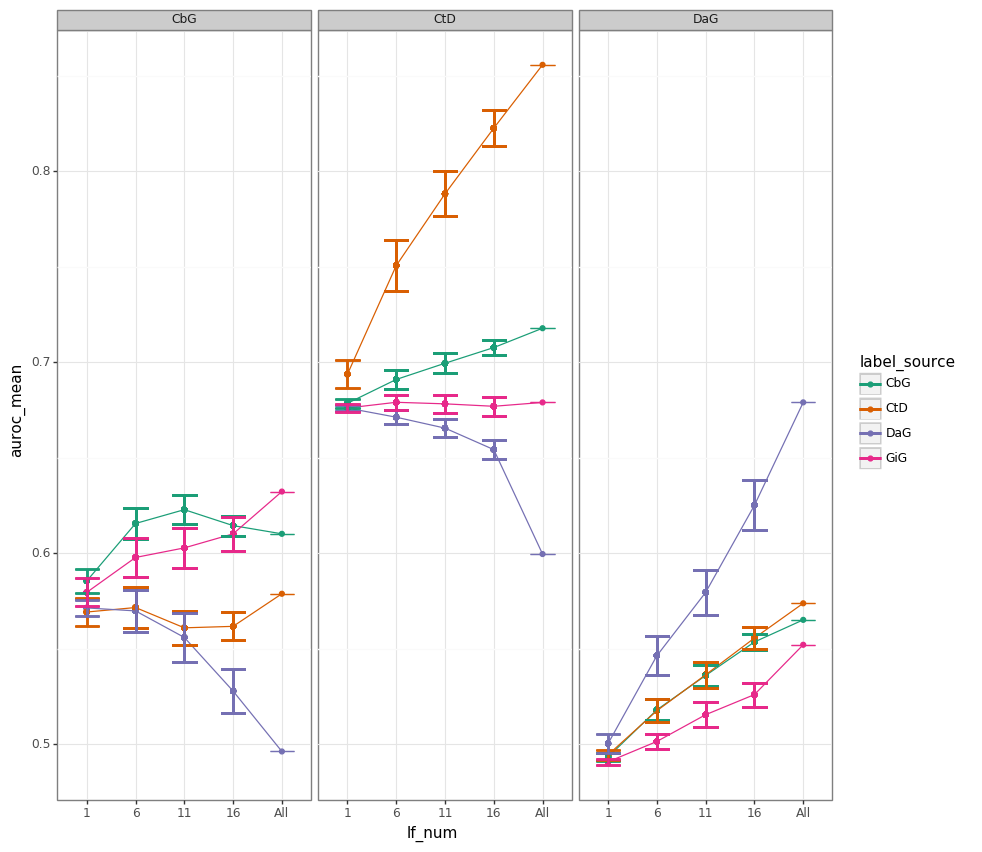

<ggplot: (8776555621580)>


In [14]:
g = (
    p9.ggplot(
        performance_ci_df
        >> ply.query("data_source=='full_text'")
        >> ply.query("model=='tune'")
    )
    + p9.aes(
        x="lf_num",
        y="auroc_mean",
        ymin="auroc_lower_ci",
        ymax="auroc_upper_ci",
        group="label_source",
        color="label_source",
    )
    + p9.geom_point()
    + p9.geom_line()
    + p9.geom_errorbar()
    + p9.facet_wrap("~ prediction_label")
    + p9.theme_bw()
    + p9.theme(figure_size=(10, 10))
    + p9.scale_color_brewer(type="qual", palette=2)
)
print(g)

### Test Set

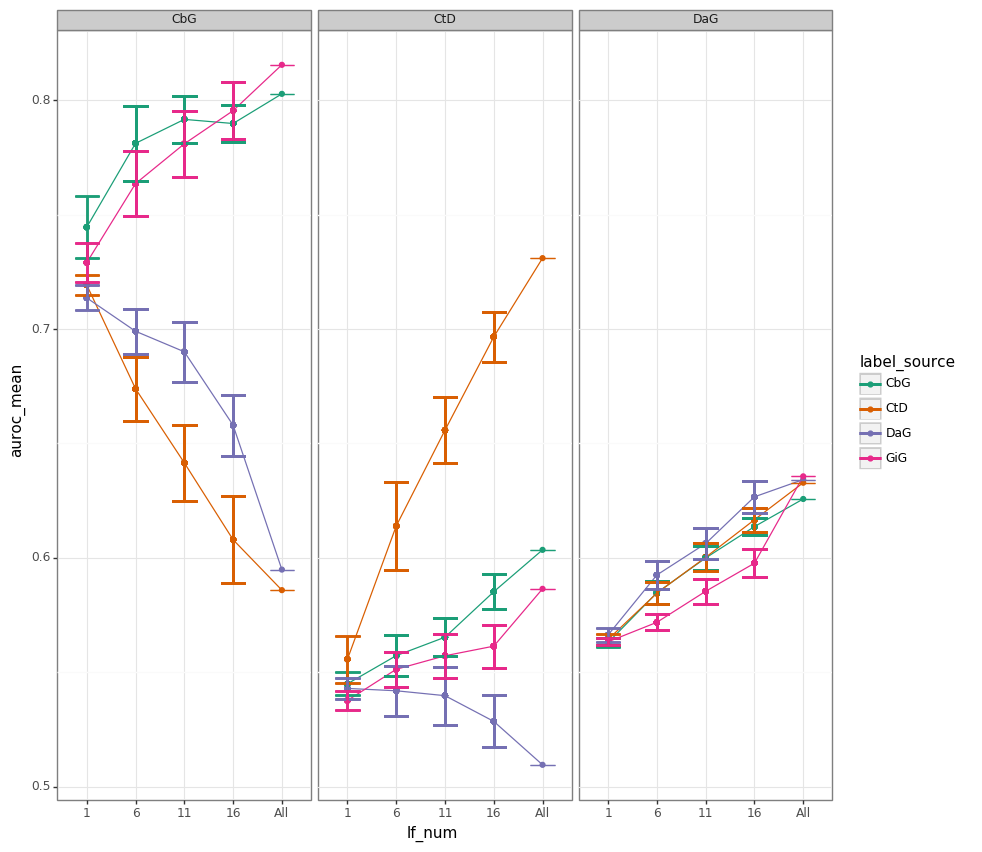

<ggplot: (-9223363260299046519)>


In [15]:
g = (
    p9.ggplot(
        performance_ci_df
        >> ply.query("data_source=='full_text'")
        >> ply.query("model=='test'")
    )
    + p9.aes(
        x="lf_num",
        y="auroc_mean",
        ymin="auroc_lower_ci",
        ymax="auroc_upper_ci",
        group="label_source",
        color="label_source",
    )
    + p9.geom_point()
    + p9.geom_line()
    + p9.geom_errorbar()
    + p9.facet_wrap("~ prediction_label")
    + p9.theme_bw()
    + p9.theme(figure_size=(10, 10))
    + p9.scale_color_brewer(type="qual", palette=2)
)
print(g)

## Binary Cross Entropy Loss (BCE)

### Tune Set

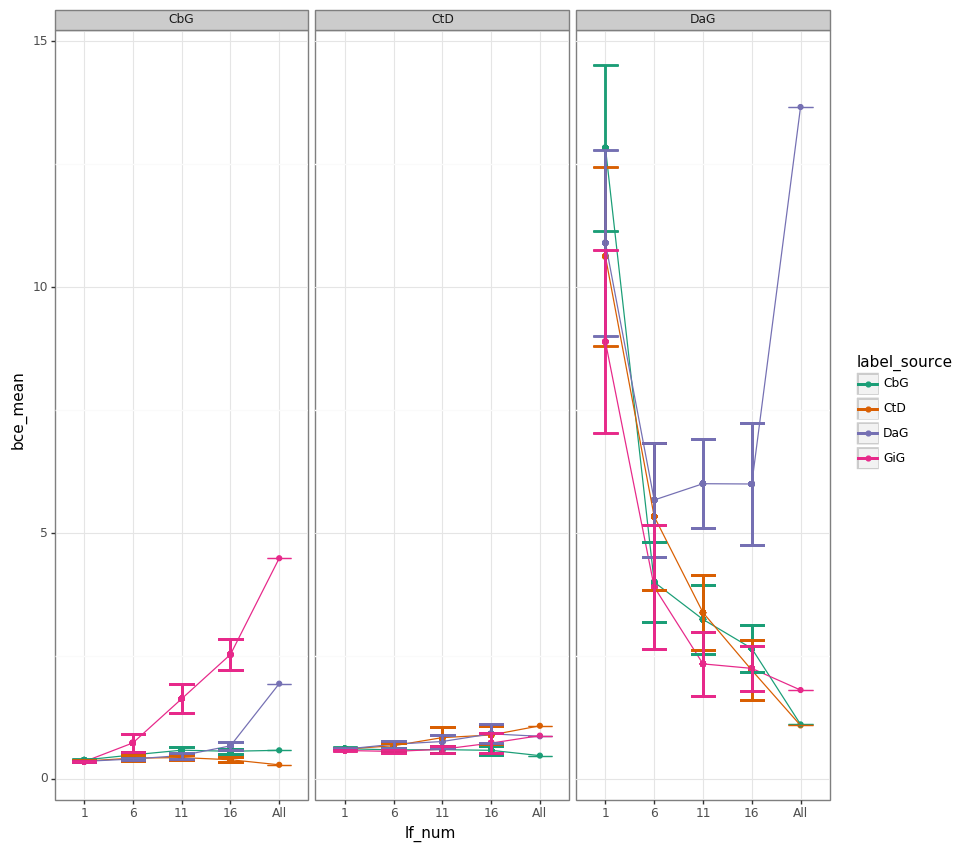

<ggplot: (-9223363260289363112)>


In [16]:
g = (
    p9.ggplot(
        performance_ci_df
        >> ply.query("data_source=='full_text'")
        >> ply.query("model=='tune'")
    )
    + p9.aes(
        x="lf_num",
        y="bce_mean",
        ymin="bce_lower_ci",
        ymax="bce_upper_ci",
        group="label_source",
        color="label_source",
    )
    + p9.geom_point()
    + p9.geom_line()
    + p9.geom_errorbar()
    + p9.facet_wrap("~ prediction_label")
    + p9.theme_bw()
    + p9.theme(figure_size=(10, 10))
    + p9.scale_color_brewer(type="qual", palette=2)
)
print(g)

### Test Set

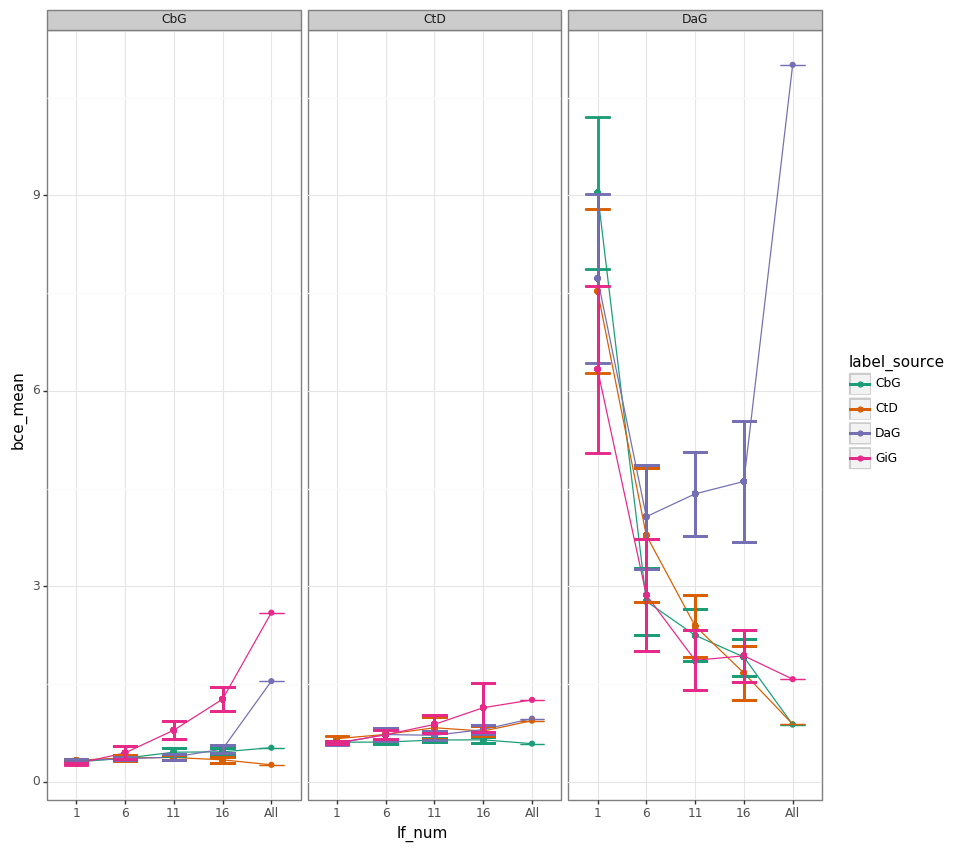

<ggplot: (8776563027976)>


In [17]:
g = (
    p9.ggplot(
        performance_ci_df
        >> ply.query("data_source=='full_text'")
        >> ply.query("model=='test'")
    )
    + p9.aes(
        x="lf_num",
        y="bce_mean",
        ymin="bce_lower_ci",
        ymax="bce_upper_ci",
        group="label_source",
        color="label_source",
    )
    + p9.geom_point()
    + p9.geom_line()
    + p9.geom_errorbar()
    + p9.facet_wrap("~ prediction_label")
    + p9.theme_bw()
    + p9.theme(figure_size=(10, 10))
    + p9.scale_color_brewer(type="qual", palette=2)
)
print(g)

# Abstracts vs Full Text

/home/danich1/anaconda3/envs/snorkeling_full_text/lib/python3.7/site-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/home/danich1/anaconda3/envs/snorkeling_full_text/lib/python3.7/site-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/home/danich1/anaconda3/envs/snorkeling_full_text/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_errorbar : Removed 4 rows containing missing values.


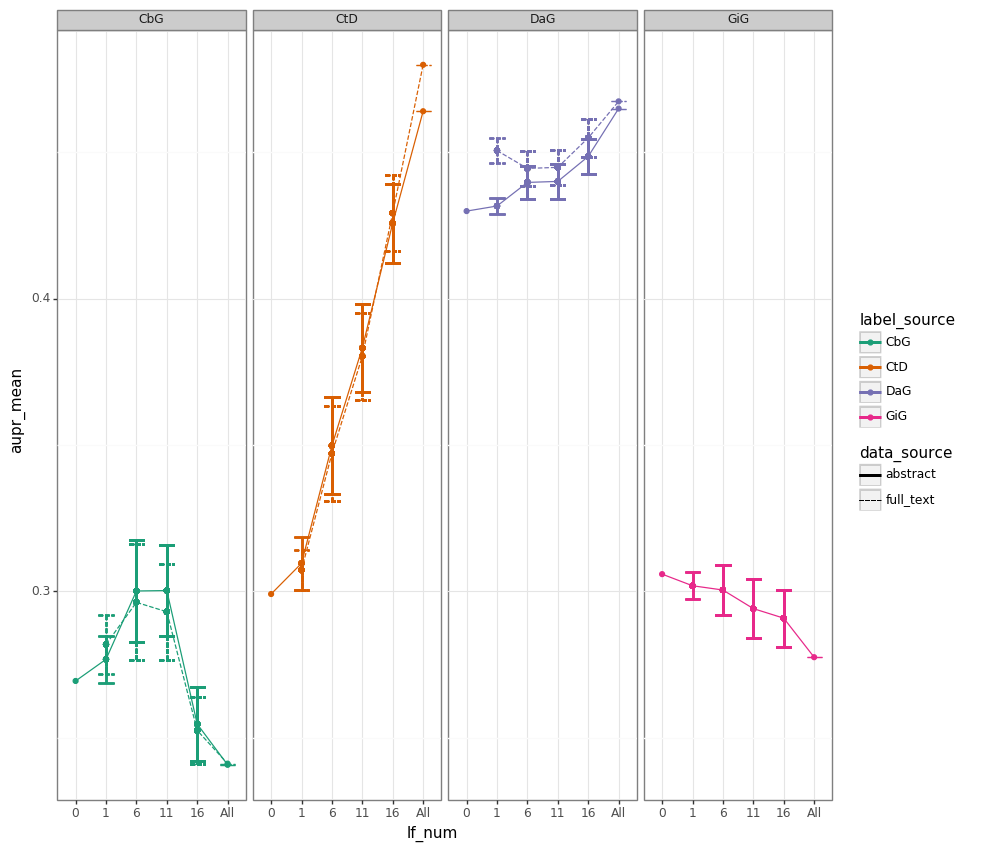

<ggplot: (-9223363260294377037)>


In [18]:
g = (
    p9.ggplot(
        performance_ci_df
        >> ply.query("prediction_label==label_source")
        >> ply.query("model=='test'")
    )
    + p9.aes(
        x="lf_num",
        y="aupr_mean",
        ymin="aupr_lower_ci",
        ymax="aupr_upper_ci",
        group="data_source",
        color="label_source",
        linetype="data_source",
    )
    + p9.geom_point()
    + p9.geom_line()
    + p9.geom_errorbar()
    + p9.facet_grid("~ prediction_label")
    + p9.theme_bw()
    + p9.theme(figure_size=(10, 10))
    + p9.scale_color_brewer(type="qual", palette=2)
)
print(g)

/home/danich1/anaconda3/envs/snorkeling_full_text/lib/python3.7/site-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/home/danich1/anaconda3/envs/snorkeling_full_text/lib/python3.7/site-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/home/danich1/anaconda3/envs/snorkeling_full_text/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_errorbar : Removed 4 rows containing missing values.


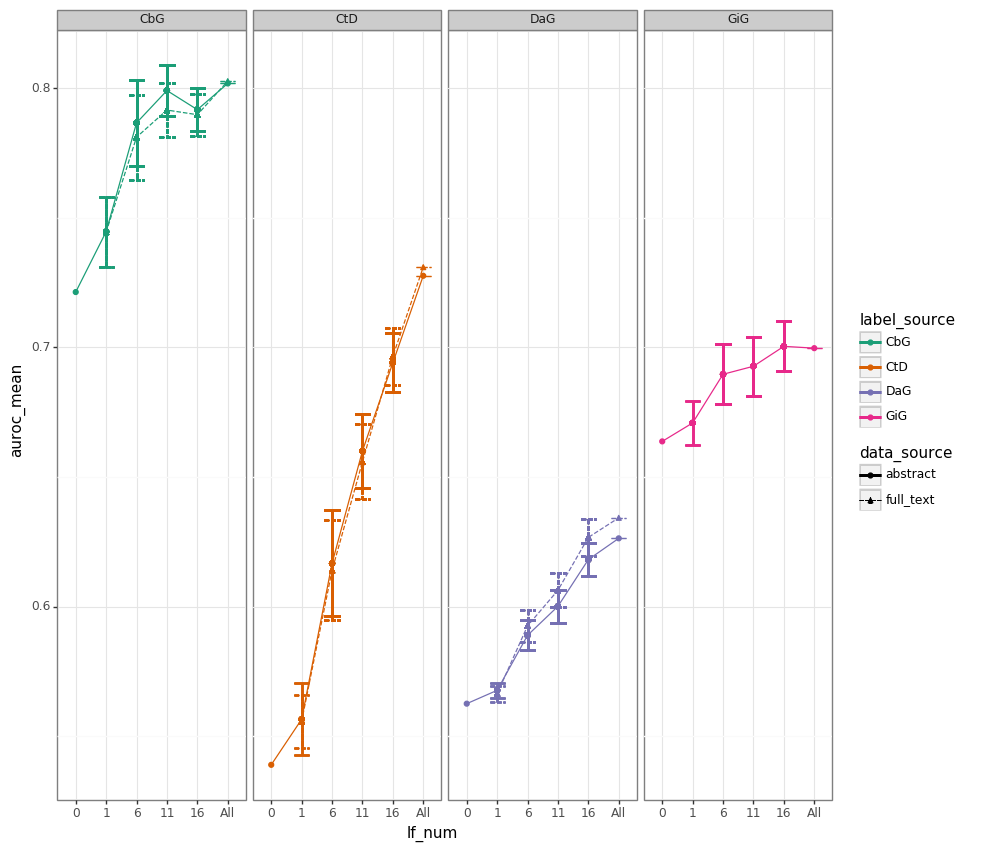

<ggplot: (-9223363260299163185)>


In [19]:
g = (
    p9.ggplot(
        performance_ci_df
        >> ply.query("prediction_label==label_source")
        >> ply.query("model=='test'")
    )
    + p9.aes(
        x="lf_num",
        y="auroc_mean",
        ymin="auroc_lower_ci",
        ymax="auroc_upper_ci",
        group="data_source",
        color="label_source",
        shape="data_source",
        linetype="data_source",
    )
    + p9.geom_point()
    + p9.geom_line()
    + p9.geom_errorbar()
    + p9.facet_grid("~ prediction_label")
    + p9.theme_bw()
    + p9.theme(figure_size=(10, 10))
    + p9.scale_color_brewer(type="qual", palette=2)
)
print(g)